In this notebook we process a large part of the glaciers in the Alps. The image is chosen in such a way that the
most important glaciers in France/Austria/Switzerland/Italy are covered.

In [3]:
# Import script to embed geolocation.
from IPython.display import HTML
import datetime

import sys
sys.path.extend(['/Users/gertmulder/software/rippl_main'])

from rippl.orbit_geometry.read_write_shapes import ReadWriteShapes
from rippl.SAR_sensors.sentinel.sentinel_download import DownloadSentinel
from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

glacier_shape = [[11.260986328125, 46.84516443029276],
            [12.095947265625, 46.803819640791545],
            [13.073730468750002, 46.830133640447386],
            [13.5955810546875, 46.9465122958623],
            [13.403320312499998, 47.204642388766935],
            [10.607299804687523, 47.247542522267985],
            [9.6240234375, 46.927758623434435],
            [8.827514648437523, 47.00835281693702],
            [7.772827148437526, 46.63246472462745],
            [6.701660156249999, 46.118941506107056],
            [6.597290039062523, 45.673563046842496],
            [6.0150146484375, 45.263288531496855],
            [6.0479736328125, 44.762336674810996],
            [6.43798828125, 44.793530904744046],
            [6.6796875, 44.98034238084973],
            [7.2894287109375,45.28261705751738],
            [7.3663330078125, 45.4947963896697],
            [8.052978515625, 45.84028105450088],
            [8.316650390625, 46.20264638061017],
            [8.9208984375, 46.244451065485066],
            [9.563598632812523, 46.1246527020117],
            [10.2557373046875, 46.1912395780416],
            [10.838012695312523, 46.50406399740095],
            [11.260986328125, 46.84516443029276]]
study_area = ReadWriteShapes()
study_area(glacier_shape)

geojson = study_area.shape

# Try to do the same by creating a shapefile with QGIS, geojson online or a .kml file in google earth.
# study_area.read_kml(kml_path)
# study_area.read_geo_json(geojson_path)
# study_area.read_shapefile(shapefile_path)

The next step in the processing is selection of the right track, as the Sentinel-1 satellite will cover the area on both
ascending and descending tracks. However, to do so, we will have to define the start and end date of our data search,
because the satellite is not always acquiring data.
Next search will give a small oversight of the available tracks during our period of interest. In our case we will
search one week before and one week after the earthquake.

Watch out with extending the search window, this can result in a lot of images. Note that every downloaded file will take approximately 4GB of disk space!

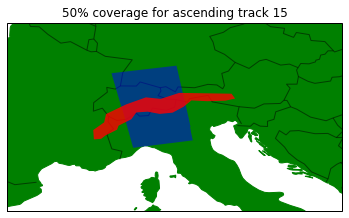

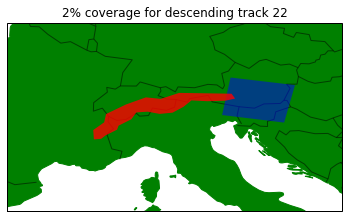

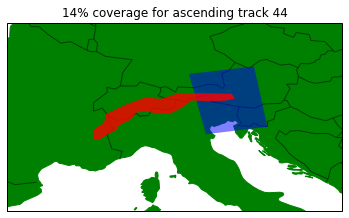

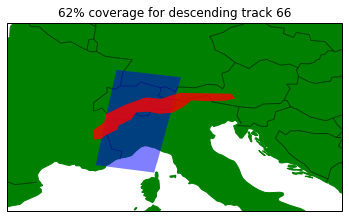

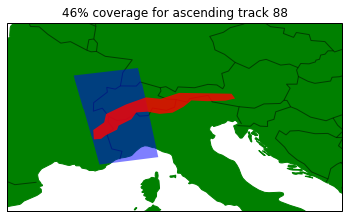

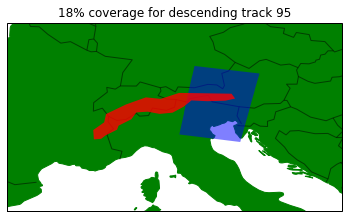

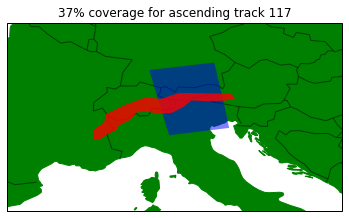

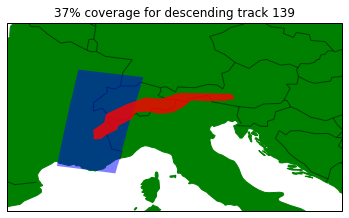

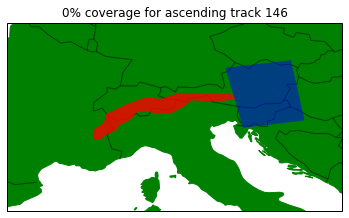

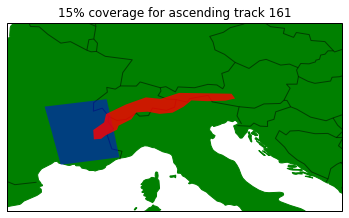

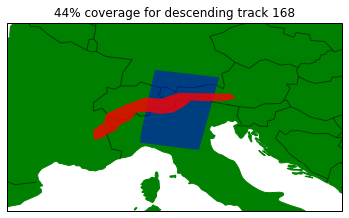

Summary statistics for Sentinel-1 search:
Stack for ascending track 015 contains 59 images with 50% coverage of area of interest
Stack for descending track 022 contains 60 images with 2% coverage of area of interest
Stack for ascending track 044 contains 60 images with 14% coverage of area of interest
Stack for descending track 066 contains 60 images with 62% coverage of area of interest
Stack for ascending track 088 contains 60 images with 46% coverage of area of interest
Stack for descending track 095 contains 59 images with 18% coverage of area of interest
Stack for ascending track 117 contains 61 images with 37% coverage of area of interest
Stack for descending track 139 contains 60 images with 37% coverage of area of interest
Stack for ascending track 146 contains 61 images with 0% coverage of area of interest
Stack for ascending track 161 contains 59 images with 15% coverage of area of interest
Stack for descending track 168 contains 61 images with 44% coverage of area of interes

In [5]:
# First we search using a time window

# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = 'VV'

# First we check using a time window
start_date = datetime.datetime(year=2017, month=10, day=1)
end_date = datetime.datetime(year=2018, month=10, day=1)

find_track = DownloadSentinel(start_date=start_date, end_date=end_date, shape=study_area.shape, sensor_mode=mode,
                              polarisation=polarisation)
find_track.sentinel_search_ASF()
find_track.summarize_search_results(plot_cartopy=True, buffer=2)

After selection of the right track we can start the actual download of the images. In our case we use track 66.

This will download our data automatically to our radar database. Additionally, it will download the precise orbit files.
These files are created within a few weeks after the data acquisition and define the satellite orbit within a few cm
accuracy. These orbits are necessary to accurately define the positions of the radar pixels on the ground later on
in the processing.


In [3]:
# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = 'VV'

from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

# Create the list of the 4 different stacks.
track_no = 66
stack_name = 'glaciers_Alps'
# For every track we have to select a master date. This is based on the search results earlier.
# Choose the date with the lowest coverage to create an image with only the overlapping parts.
master_date = datetime.datetime(year=2018, month=8, day=20)

# Number of processes for parallel processing. Make sure that for every process at least 2GB of RAM is available
no_processes = 6

s1_processing = GeneralPipelines(processes=no_processes)
s1_processing.download_sentinel_data(start_date=start_date, end_date=end_date, track=track_no,
                                           polarisation=polarisation, shapefile=study_area.shape, data=True, source='ASF')
s1_processing.create_sentinel_stack(start_date=start_date, end_date=end_date, master_date=master_date, cores=no_processes,
                                          track=track_no,stack_name=stack_name, polarisation=polarisation,
                                          shapefile=study_area.shape, mode=mode, product_type=product_type)

# Finally load the stack itself. If you want to skip the download step later, run this line before other steps!
s1_processing.read_stack(start_date=start_date, end_date=end_date, stack_name=stack_name)

Loading available orbit data files
Finished loading date files
S1A_IW_SLC__1SDV_20180428T053510_20180428T053537_021663_0255BA_B79E.zip
S1A_IW_SLC__1SDV_20180428T053445_20180428T053512_021663_0255BA_71D0.zip
S1A_IW_SLC__1SDV_20180428T053535_20180428T053602_021663_0255BA_FBC3.zip
S1B_IW_SLC__1SDV_20180104T053456_20180104T053523_009017_0101B8_4360.zip
S1B_IW_SLC__1SDV_20180104T053407_20180104T053434_009017_0101B8_0AEA.zip
S1B_IW_SLC__1SDV_20180104T053432_20180104T053459_009017_0101B8_13FB.zip
S1A_IW_SLC__1SDV_20180919T053518_20180919T053545_023763_029771_2C55.zip
S1A_IW_SLC__1SDV_20180919T053543_20180919T053610_023763_029771_9C2E.zip
S1A_IW_SLC__1SDV_20180919T053453_20180919T053520_023763_029771_0D64.zip
S1A_IW_SLC__1SDV_20180215T053509_20180215T053536_020613_0234A1_EB90.zip
S1A_IW_SLC__1SDV_20180215T053534_20180215T053601_020613_0234A1_C714.zip
S1A_IW_SLC__1SDV_20180215T053444_20180215T053511_020613_0234A1_8B94.zip
S1A_IW_SLC__1SDV_20180627T053538_20180627T053605_022538_0270FA_32BD.zip
S

Read meta_data s1a-iw1-slc-vv-20180428t053447-20180428t053512-021663-0255ba-004.xml
Read meta_data s1a-iw2-slc-vv-20180428t053445-20180428t053511-021663-0255ba-005.xml
Read meta_data s1a-iw3-slc-vv-20180428t053446-20180428t053512-021663-0255ba-006.xml
Read meta_data s1a-iw1-slc-vv-20180428t053537-20180428t053602-021663-0255ba-004.xml
Read meta_data s1a-iw2-slc-vv-20180428t053535-20180428t053600-021663-0255ba-005.xml
Read meta_data s1a-iw3-slc-vv-20180428t053536-20180428t053601-021663-0255ba-006.xml
Read meta_data s1b-iw1-slc-vv-20180104t053457-20180104t053522-009017-0101b8-004.xml
Read meta_data s1b-iw2-slc-vv-20180104t053458-20180104t053523-009017-0101b8-005.xml
Read meta_data s1b-iw3-slc-vv-20180104t053456-20180104t053522-009017-0101b8-006.xml
Read meta_data s1b-iw1-slc-vv-20180104t053408-20180104t053433-009017-0101b8-004.xml
Read meta_data s1b-iw2-slc-vv-20180104t053409-20180104t053434-009017-0101b8-005.xml
Read meta_data s1b-iw3-slc-vv-20180104t053407-20180104t053432-009017-0101b8-

Read meta_data s1b-iw2-slc-vv-20171211t053459-20171211t053525-008667-00f676-005.xml
Read meta_data s1b-iw3-slc-vv-20171211t053458-20171211t053523-008667-00f676-006.xml
Read meta_data s1a-iw1-slc-vv-20180814t053518-20180814t053543-023238-02869a-004.xml
Read meta_data s1a-iw2-slc-vv-20180814t053516-20180814t053542-023238-02869a-005.xml
Read meta_data s1a-iw3-slc-vv-20180814t053517-20180814t053543-023238-02869a-006.xml
Read meta_data s1a-iw1-slc-vv-20180814t053453-20180814t053519-023238-02869a-004.xml
Read meta_data s1a-iw2-slc-vv-20180814t053452-20180814t053517-023238-02869a-005.xml
Read meta_data s1a-iw3-slc-vv-20180814t053453-20180814t053518-023238-02869a-006.xml
Read meta_data s1a-iw1-slc-vv-20180814t053543-20180814t053608-023238-02869a-004.xml
Read meta_data s1a-iw2-slc-vv-20180814t053541-20180814t053606-023238-02869a-005.xml
Read meta_data s1a-iw3-slc-vv-20180814t053542-20180814t053607-023238-02869a-006.xml
Read meta_data s1a-iw1-slc-vv-20180122t053511-20180122t053536-020263-022975-

Read meta_data s1a-iw1-slc-vv-20180404t053511-20180404t053536-021313-024acd-004.xml
Read meta_data s1a-iw2-slc-vv-20180404t053509-20180404t053534-021313-024acd-005.xml
Read meta_data s1a-iw3-slc-vv-20180404t053510-20180404t053535-021313-024acd-006.xml
Read meta_data s1a-iw1-slc-vv-20180404t053536-20180404t053601-021313-024acd-004.xml
Read meta_data s1a-iw2-slc-vv-20180404t053534-20180404t053559-021313-024acd-005.xml
Read meta_data s1a-iw3-slc-vv-20180404t053535-20180404t053600-021313-024acd-006.xml
Read meta_data s1a-iw1-slc-vv-20180404t053446-20180404t053511-021313-024acd-004.xml
Read meta_data s1a-iw2-slc-vv-20180404t053444-20180404t053509-021313-024acd-005.xml
Read meta_data s1a-iw3-slc-vv-20180404t053445-20180404t053510-021313-024acd-006.xml
Read meta_data s1a-iw1-slc-vv-20180826t053544-20180826t053609-023413-028c38-004.xml
Read meta_data s1a-iw2-slc-vv-20180826t053542-20180826t053607-023413-028c38-005.xml
Read meta_data s1a-iw3-slc-vv-20180826t053543-20180826t053608-023413-028c38-

Read meta_data s1b-iw2-slc-vv-20180410t053458-20180410t053523-010417-012f98-005.xml
Read meta_data s1b-iw3-slc-vv-20180410t053456-20180410t053521-010417-012f98-006.xml
Read meta_data s1a-iw1-slc-vv-20171006t053538-20171006t053604-018688-01f871-004.xml
Read meta_data s1a-iw2-slc-vv-20171006t053537-20171006t053602-018688-01f871-005.xml
Read meta_data s1a-iw3-slc-vv-20171006t053538-20171006t053603-018688-01f871-006.xml
Read meta_data s1a-iw1-slc-vv-20171006t053449-20171006t053514-018688-01f871-004.xml
Read meta_data s1a-iw2-slc-vv-20171006t053447-20171006t053512-018688-01f871-005.xml
Read meta_data s1a-iw3-slc-vv-20171006t053448-20171006t053513-018688-01f871-006.xml
Read meta_data s1a-iw1-slc-vv-20171006t053514-20171006t053539-018688-01f871-004.xml
Read meta_data s1a-iw2-slc-vv-20171006t053512-20171006t053537-018688-01f871-005.xml
Read meta_data s1a-iw3-slc-vv-20171006t053513-20171006t053538-018688-01f871-006.xml
Read meta_data s1b-iw1-slc-vv-20180727t053508-20180727t053534-011992-016138-

Read meta_data s1a-iw1-slc-vv-20171111t053513-20171111t053539-019213-02087f-004.xml
Read meta_data s1a-iw2-slc-vv-20171111t053512-20171111t053537-019213-02087f-005.xml
Read meta_data s1a-iw3-slc-vv-20171111t053513-20171111t053538-019213-02087f-006.xml
Read meta_data s1a-iw1-slc-vv-20171111t053538-20171111t053603-019213-02087f-004.xml
Read meta_data s1a-iw2-slc-vv-20171111t053536-20171111t053602-019213-02087f-005.xml
Read meta_data s1a-iw3-slc-vv-20171111t053537-20171111t053603-019213-02087f-006.xml
Read meta_data s1a-iw1-slc-vv-20171111t053449-20171111t053514-019213-02087f-004.xml
Read meta_data s1a-iw2-slc-vv-20171111t053447-20171111t053512-019213-02087f-005.xml
Read meta_data s1a-iw3-slc-vv-20171111t053448-20171111t053513-019213-02087f-006.xml
Read meta_data s1b-iw1-slc-vv-20180808t053419-20180808t053444-012167-01668a-004.xml
Read meta_data s1b-iw2-slc-vv-20180808t053417-20180808t053443-012167-01668a-005.xml
Read meta_data s1b-iw3-slc-vv-20180808t053418-20180808t053444-012167-01668a-

Read meta_data s1b-iw1-slc-vv-20180504t053433-20180504t053458-010767-013ad2-004.xml
Read meta_data s1b-iw2-slc-vv-20180504t053434-20180504t053459-010767-013ad2-005.xml
Read meta_data s1b-iw3-slc-vv-20180504t053432-20180504t053457-010767-013ad2-006.xml
Read meta_data s1b-iw1-slc-vv-20180504t053408-20180504t053433-010767-013ad2-004.xml
Read meta_data s1b-iw2-slc-vv-20180504t053409-20180504t053434-010767-013ad2-005.xml
Read meta_data s1b-iw3-slc-vv-20180504t053407-20180504t053433-010767-013ad2-006.xml
Read meta_data s1b-iw1-slc-vv-20180504t053458-20180504t053523-010767-013ad2-004.xml
Read meta_data s1b-iw2-slc-vv-20180504t053459-20180504t053524-010767-013ad2-005.xml
Read meta_data s1b-iw3-slc-vv-20180504t053457-20180504t053522-010767-013ad2-006.xml
Read meta_data s1a-iw1-slc-vv-20180510t053513-20180510t053538-021838-025b48-004.xml
Read meta_data s1a-iw2-slc-vv-20180510t053511-20180510t053536-021838-025b48-005.xml
Read meta_data s1a-iw3-slc-vv-20180510t053512-20180510t053537-021838-025b48-

Initializing master bursts 0 to 32 from total of 32
Initializing slave bursts 0 to 100 from total of 1888
Initializing slave bursts 100 to 200 from total of 1888
Initializing slave bursts 200 to 300 from total of 1888
Initializing slave bursts 300 to 400 from total of 1888
Initializing slave bursts 400 to 500 from total of 1888
Initializing slave bursts 500 to 600 from total of 1888
Initializing slave bursts 600 to 700 from total of 1888
Initializing slave bursts 700 to 800 from total of 1888
Initializing slave bursts 800 to 900 from total of 1888
Initializing slave bursts 900 to 1000 from total of 1888
Initializing slave bursts 1000 to 1100 from total of 1888
Initializing slave bursts 1100 to 1200 from total of 1888
Initializing slave bursts 1200 to 1300 from total of 1888
Initializing slave bursts 1300 to 1400 from total of 1888
Initializing slave bursts 1400 to 1500 from total of 1888
Initializing slave bursts 1500 to 1600 from total of 1888
Initializing slave bursts 1600 to 1700 fr

To define the location of the radar pixels on the ground we need the terrain elevation. Although it is possible to 
derive terrain elevation from InSAR data, our used Sentinel-1 dataset is not suitable for this purpose. Therefore, we
download data from an external source to create a digital elevation model (DEM). In our case we use SRTM data. 

However, to find the elevation of the SAR data grid, we have to resample the data to the radar grid first to make it
usable. This is done in the next steps.

In [4]:
# Some basic settings for DEM creation.
dem_buffer = 0.1        # Buffer around radar image where DEM data is downloaded
dem_rounding = 0.1      # Rounding of DEM size in degrees
dem_type = 'SRTM3'      # DEM type of data we download (SRTM1, SRTM3 and TanDEM-X are supported)

# Define both the coordinate system of the full radar image and imported DEM
s1_processing.create_radar_coordinates()
s1_processing.create_dem_coordinates(dem_type=dem_type)

# Download external DEM
s1_processing.download_external_dem(buffer=dem_buffer, rounding=dem_rounding, n_processes=no_processes)

Using the obtained elevation model the exact location of the radar pixels in cartesian (X,Y,Z) and geographic (Lat/Lon)
can be derived. This is only done for the master or reference image. This process is referred to as geocoding.

In [5]:
# Geocoding of image
s1_processing.geocoding()

Processing pipeline block 1 out of 4
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 2 out of 4
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 3 out of 4
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping proces

The information from the geocoding can directly be used to find the location of the master grid pixels in the slave
grid images. This process is called coregistration. Because the orbits are not exactly the same with every satellite 
overpass but differ hundreds to a few thousand meters every overpass, the grids are slightly shifted with respect to 
each other. These shift are referred to as the spatial baseline of the images. To correctly overlay the master and slave
images the software coregisters and resamples to the master grid.

To do so the following steps are done:
1. Coregistration of slave to master image
2. Deramping the doppler effects due to TOPs mode of Sentinel-1 satellite
3. Resampling of slave image
4. Reramping resampled slave image.

Due to the different orbits of the master and slave image, the phase of the radar signal is also shifted. We do not 
know the exact shift of the two image, but using the geometry of the two images we can estimate the shift of the phase
between different pixels. Often this shift is split in two contributions:
1. The flat earth phase. This phase is the shift in the case the earth was a perfect ellipsoid
2. The topographic phase. This is the phase shift due to the topography on the ground.
In our processing these two corrections are done in one go.

In [6]:
# Next step applies resampling and phase correction in one step.
# Polarisation
s1_processing.geometric_coregistration_resampling(polarisation=polarisation, output_phase_correction=True)

Processing pipeline block 1 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 2 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 3 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping 

Processing pipeline block 22 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 23 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 24 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skippi

Processing pipeline block 43 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 44 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 45 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skippi

Processing pipeline block 64 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 65 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 66 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skippi

Processing pipeline block 85 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 86 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 87 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skippi

Processing pipeline block 106 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 107 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 108 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Processing pipeline block 127 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 128 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 129 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Processing pipeline block 148 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 149 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 150 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Processing pipeline block 169 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 170 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 171 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Processing pipeline block 190 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 191 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 192 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Processing pipeline block 211 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 212 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 213 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Processing pipeline block 232 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 233 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 234 out of 240
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Ski

Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset alread

Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Using predefined grid size for concatenation of slices
Concatenated dataset alread

Now we can create calibrated amplitudes, interferograms and coherences.

In [7]:
for dist in [50, 100, 200]:

    # The actual creation of the calibrated amplitude images
    s1_processing.create_ml_coordinates(standard_type='oblique_mercator', dx=dist, dy=dist, buffer=0, rounding=0)
    s1_processing.prepare_multilooking_grid(polarisation)
    s1_processing.create_calibrated_amplitude_multilooked(polarisation)
    s1_processing.create_output_tiffs_amplitude()

    s1_processing.create_ifg_network(temporal_baseline=15)
    s1_processing.create_interferogram_multilooked(polarisation)
    s1_processing.create_coherence_multilooked(polarisation)

    # Create output geotiffs
    s1_processing.create_output_tiffs_coherence_ifg()

    # Create lat/lon/incidence angle/DEM for multilooked grid.
    s1_processing.create_geometry_mulitlooked()
    s1_processing.create_output_tiffs_geometry()

Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 8
Processing pipeline block 2 out of 8
Processing pipeline block 3 out of 8
Processing pipeline block 4 out of 8
Processing pipeline block 5 out of 8
Processing pipeline block 6 out of 8
Processing pipeline block 7 out of 8
Processing pipeline block 8 out of 8
Processing 0 out of 34
Processing 1 out of 34
Processing 2 out of 34
Processing 3 out of 34
Processing 4 out of 34
Processing 5 out of 34
Processing 6 out of 34
Processing 7 out of 34
Processing 8 out of 34
Processing 9 out of 34
Processing 10 out of 34
Processing 11 out of 34
Processing 12 out of 34
Processing 13 out of 34
Processing 14 out of 34
Processing 15 out of 34
Processing 16 out of 34
Processing 17 out of 34
Processing 18 out of 34
Processing 19 out of 34
Processing 20 out of 34
Processing 21 out of 34
Processing

/home/gert/Software/rippl_main/rippl/meta_data/image_data.py:460: RuntimeWarning: divide by zero encountered in log
  data.GetRasterBand(1).WriteArray(np.log(np.abs(self.memory['data'])))


Processing pipeline block 1 out of 1
Skipping processing. Process already finished
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 1
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 8
Processing pipeline block 2 out of 8
Processing pipeline block 3 out of 8
Processing pipeline block 4 out of 8
Processing pipeline block 5 out of 8
Processing pipeline block 6 out of 8
Processing pipeline block 7 out of 8
Processing pipeline block 8 out of 8
Processing 0 out of 34
Processing 1 out of 34
Processing 2 out of 34
Processing 3 out of 34
Processing 4 out of 34
Processing 5 out of 34
Processing 6 out of 34
Processing 7 out of 34
Processing 8 out of 34
Processing 9 out of 34
Processing 10 out of 34
Processing 11 out of 34
Processing 12 out of 34
Processing 13 out of 34
Processing 14 out of 34
Processing 15 out of 

/home/gert/Software/rippl_main/rippl/meta_data/image_data.py:460: RuntimeWarning: divide by zero encountered in log
  data.GetRasterBand(1).WriteArray(np.log(np.abs(self.memory['data'])))


Processing pipeline block 1 out of 1
Skipping processing. Process already finished
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 1
Using predefined grid size for concatenation of slices
Concatenated dataset already exists. If you want to overwrite set overwrite to True
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 8
Processing pipeline block 2 out of 8
Processing pipeline block 3 out of 8
Processing pipeline block 4 out of 8
Processing pipeline block 5 out of 8
Processing pipeline block 6 out of 8
Processing pipeline block 7 out of 8
Processing pipeline block 8 out of 8
Processing 0 out of 34
Processing 1 out of 34
Processing 2 out of 34
Processing 3 out of 34
Processing 4 out of 34
Processing 5 out of 34
Processing 6 out of 34
Processing 7 out of 34
Processing 8 out of 34
Processing 9 out of 34
Processing 10 out of 34
Processing 11 out of 34
Processing 12 out of 34
Processing 13 out of 34
Processing 14 out of 34
Processing 15 out of 

/home/gert/Software/rippl_main/rippl/meta_data/image_data.py:460: RuntimeWarning: divide by zero encountered in log
  data.GetRasterBand(1).WriteArray(np.log(np.abs(self.memory['data'])))


Processing pipeline block 1 out of 1
Skipping processing. Process already finished
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 1
